In [2]:
#Import Libraries
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import random
%matplotlib inline
import tensorflow as tf
import shutil
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
from tensorflow.contrib.learn.python.learn import learn_runner
import tensorflow.contrib.metrics as metrics
import tensorflow.contrib.rnn as rnn

(4278,)


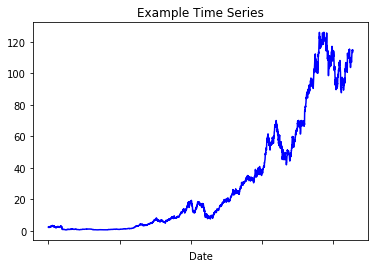

Date
1999-12-31    2.485700
2000-01-03    2.706315
2000-01-04    2.478144
2000-01-05    2.514410
2000-01-06    2.296816
2000-01-07    2.405613
2000-01-10    2.363304
2000-01-11    2.242418
2000-01-12    2.107934
2000-01-13    2.339126
Name: AAPL, dtype: float64

In [36]:
ticker = 'AAPL'
random.seed(111)
rng = pd.date_range(start='2000', periods=209, freq='M')

ts = pd.Series(np.random.uniform(-10, 10, size=len(rng)), rng).cumsum()

df = pd.read_csv('sp500_joined_closes.csv', index_col = 0)
df = df[ticker]
df = df.dropna(how='any')
print(df.shape)
ts = df

ts.plot(c='b', title='Example Time Series')
plt.show()
ts.head(10)

In [37]:
TS = np.array(ts)
num_periods = 20
f_horizon = 1  #forecast horizon, one period into the future

x_data = TS[:(len(TS)-(len(TS) % num_periods))]
x_batches = x_data.reshape(-1, 20, 1)

y_data = TS[1:(len(TS)-(len(TS) % num_periods))+f_horizon]
y_batches = y_data.reshape(-1, 20, 1)
print (len(x_batches))
print (x_batches.shape)
print (x_batches[0:2])

print (y_batches[0:1])
print (y_batches.shape)

213
(213, 20, 1)
[[[2.4857  ]
  [2.706315]
  [2.478144]
  [2.51441 ]
  [2.296816]
  [2.405613]
  [2.363304]
  [2.242418]
  [2.107934]
  [2.339126]
  [2.42828 ]
  [2.512899]
  [2.576363]
  [2.744092]
  [2.691205]
  [2.568808]
  [2.71387 ]
  [2.664006]
  [2.659472]
  [2.456989]]

 [[2.508365]
  [2.423746]
  [2.388992]
  [2.497789]
  [2.611118]
  [2.757692]
  [2.777336]
  [2.722937]
  [2.744092]
  [2.629251]
  [2.800001]
  [2.877066]
  [2.759202]
  [2.777336]
  [2.689693]
  [2.751647]
  [2.810579]
  [2.785268]
  [2.668538]
  [2.738047]]]
[[[2.706315]
  [2.478144]
  [2.51441 ]
  [2.296816]
  [2.405613]
  [2.363304]
  [2.242418]
  [2.107934]
  [2.339126]
  [2.42828 ]
  [2.512899]
  [2.576363]
  [2.744092]
  [2.691205]
  [2.568808]
  [2.71387 ]
  [2.664006]
  [2.659472]
  [2.456989]
  [2.508365]]]
(213, 20, 1)


In [38]:
def test_data(series,forecast,num_periods):
    test_x_setup = TS[-(num_periods + forecast):]
    testX = test_x_setup[:num_periods].reshape(-1, 20, 1)
    testY = TS[-(num_periods):].reshape(-1, 20, 1)
    return testX,testY

X_test, Y_test = test_data(TS,f_horizon,num_periods )
print (X_test.shape)
print (X_test)
print (Y_test.shape)

(1, 20, 1)
[[[107.319603]
  [107.721481]
  [106.947136]
  [107.770485]
  [108.829071]
  [109.897476]
  [111.6912  ]
  [111.054085]
  [112.906616]
  [112.906616]
  [113.524132]
  [113.671158]
  [114.327873]
  [114.631729]
  [114.739555]
  [113.984818]
  [114.210243]
  [114.935585]
  [114.445503]
  [114.416092]]]
(1, 20, 1)


In [39]:
tf.reset_default_graph()   

num_periods = 20      
inputs = 1            
hidden = 100          
output = 1            

X = tf.placeholder(tf.float32, [None, num_periods, inputs])   
y = tf.placeholder(tf.float32, [None, num_periods, output])


basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=hidden, activation=tf.nn.relu)   
rnn_output, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)             

learning_rate = 0.01   

stacked_rnn_output = tf.reshape(rnn_output, [-1, hidden])           
stacked_outputs = tf.layers.dense(stacked_rnn_output, output)       
outputs = tf.reshape(stacked_outputs, [-1, num_periods, output])    
 
loss = tf.reduce_sum(tf.square(outputs - y))    
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)          
training_op = optimizer.minimize(loss)        

init = tf.global_variables_initializer()      

In [27]:
epochs = 10000     #number of iterations or training cycles

with tf.Session() as sess:
    init.run()
    for ep in range(epochs):
        sess.run(training_op, feed_dict={X: x_batches, y: y_batches})
        if ep % 100 == 0:
            mse = loss.eval(feed_dict={X: x_batches, y: y_batches})
            print(ep, "\tMSE:", mse)
    
    y_pred = sess.run(outputs, feed_dict={X: X_test})
    print(y_pred)

0 	MSE: 1112198.8
100 	MSE: 10294.721
200 	MSE: 3007.9644
300 	MSE: 2917.0015
400 	MSE: 2877.744
500 	MSE: 2854.2573
600 	MSE: 2838.3987
700 	MSE: 2824.1387
800 	MSE: 2808.5317
900 	MSE: 2794.1062
1000 	MSE: 2780.5269
1100 	MSE: 2766.6182
1200 	MSE: 2752.1968
1300 	MSE: 2737.0544
1400 	MSE: 2721.5654
1500 	MSE: 2705.6526
1600 	MSE: 2689.3418
1700 	MSE: 2672.7083
1800 	MSE: 2655.7446
1900 	MSE: 2638.7708
2000 	MSE: 2622.0503
2100 	MSE: 2605.0771
2200 	MSE: 2588.3486
2300 	MSE: 2572.1191
2400 	MSE: 2556.6614
2500 	MSE: 2541.9912
2600 	MSE: 2527.769
2700 	MSE: 2514.863
2800 	MSE: 2502.7227
2900 	MSE: 2491.0579
3000 	MSE: 2481.2817
3100 	MSE: 2472.3252
3200 	MSE: 2464.7234
3300 	MSE: 2458.104
3400 	MSE: 2452.692
3500 	MSE: 2449.0771
3600 	MSE: 2444.4568
3700 	MSE: 2443.7231
3800 	MSE: 2439.2795
3900 	MSE: 2438.022
4000 	MSE: 2436.2573
4100 	MSE: 2517.3623
4200 	MSE: 2434.2258
4300 	MSE: 2433.1604
4400 	MSE: 2438.7021
4500 	MSE: 2431.279
4600 	MSE: 2431.648
4700 	MSE: 2429.785
4800 	MSE: 24

[[[3.94481981e-02]
  [4.76524503e-01]
  [1.60501421e+00]
  [5.51747981e-03]
  [1.58641309e+00]
  [5.65179111e+00]
  [6.11997412e-01]
  [1.33804296e+00]
  [3.57595520e-02]
  [4.48529882e-01]
  [1.28530226e-04]
  [1.49892021e+00]
  [2.05287582e-01]
  [1.50093025e-02]
  [7.76446418e-02]
  [3.99193842e-02]
  [6.98306846e-01]
  [1.74200966e-01]
  [3.09393226e-02]
  [5.04477632e-01]]]
0.7521936410342309


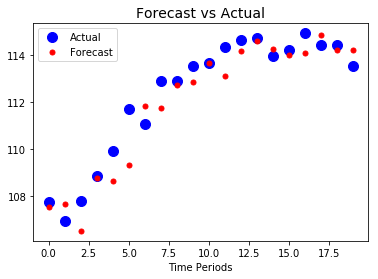

In [34]:
plt.title("Forecast vs Actual", fontsize=14)
plt.plot(pd.Series(np.ravel(Y_test)), "bo", markersize=10, label="Actual")
#plt.plot(pd.Series(np.ravel(Y_test)), "w*", markersize=10)
plt.plot(pd.Series(np.ravel(y_pred)), "r.", markersize=10, label="Forecast")
plt.legend(loc="upper left")
plt.xlabel("Time Periods")

print ((Y_test - y_pred) ** 2)
mse = np.mean((Y_test - y_pred) ** 2)
print(mse)

plt.show()

In [35]:
# Prepare data for training

def prepare_data(ticker):data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAXoAAAEXCAYAAACjyo8UAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMS4yLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvNQv5yAAAIABJREFUeJzt3Xt8XVWd9/HPLyG2NmlRCsMwVCnTYfBC2wQjsQJyqRJiKwKWgWo7XByrVn2w1JfCAwJDZ+YRBMvjbWa0QBmK8VJFoZAJKAIyjwYCiaVQLo0FLXIprZYkBUxPf88fa59ycprLTs79nO/79dqvfc7ea++9zs7Jb6+z9tprmbsjIiLlq6rQGRARkdxSoBcRKXMK9CIiZU6BXkSkzCnQi4iUOQV6EZEyp0AvInsxs9Vmtq7Q+ZDsUKCXUUX/9D7EVF/ovGXCzI6PPsf+BczD180sYWafGMe2T5vZF3KRLykvCvQS18+Bg9KmDePdmZnVZClfJcvMJgAfA74C/FOBsyNlTIFe4nrN3Z9Pm3ZBCFhmdq2ZvWBmr5rZb8zsmOSGKSXnD5rZA2b2F6A5WvchM3so2m6zmf2rmb0hZds3mNm/mdkzZvaamf3OzP5XtK7azK6LtnvFzJ4ysy+aWVXK9jPN7Bdm9rKZ9ZnZb83sBDObDvwySrY1yt/q9A9tZlVm9gcz+1za8r+Ptjkyev9JM3sy+hwvmVm7me0zyjk9HXga+FfgHWZ2xBDH/6CZdUSfb5uZ3WZmE83sHuAQ4KvJX1hR+nPMrC9tH4N+uZjZVDNrNbMt0X4fNbNzR8mrlLDRvogicVwF/ANwHvA74ALgv83sMHd/LiXdlcByYBPQa2bNwM3A+cB9wFuB/wAmAMkqiRuBY6M0XYTg9pZoXRXwbHTsrcBRwHeAbcB1UZrvAb+N1u0CZgKvAn8APgL8GHgnsB14Jf2DuftuM2sllLy/kbLqY8BGd3/YzBqBbwFnA/cDbwJOjHHe/glY4+47zezH0fvPJ1ea2cnArYQS/7mE/9eTos99evS5rgf+PcaxUk0EHib8PV4G3g/8p5n93t1/McZ9SSlwd02aRpyA1YQg2ZcytUXraoG/AP+Ykr4a6AH+JXp/PODAR9L2ex/w5bRlp0b7N+CwaLuTx5DXrwA/T3n/MnD2MGmT+dp/lH3OitLNSFn2FPC/o9enAzuAyWPI56HRefvr6P2JwEvAhJQ0/wN8f4R9PA18IW3ZOUDfWD8n8H1gVdrffF2hv3uasjOp6kbiug+oT5mSdcozgBpCUALA3RPAr4F3pO2jM+39u4CLoyqVvqjK4XuEi8dfAw3Abl6vYtmLmX3KzDrNbGu0/TLCL4OkrwGrzOxuM7vYzN42lg8dfZ71wCOEUjxm1hR97pujJHcBzwCbzexmMzvbzCaPstuPA79w9+ej9/cAOwkXuqQGIOsl7KjK62IzWx9VB/URLlZvHW1bKU0K9BLXTnfflDI9G2Ob9K5R+9PeVwH/zOALyCxCSX7raDs3szOBawmlz+Zo+28De+r43f1ywgXnp8B7gfVmdl6MvKdbQxToo/n97v5MdIxe4EhCFdLvgYuAx83sb4bJdzWh5N1sZrvMbBehdD+NzG/K7ib8GkqVfuP7C4QqtK8Ccwnn7aeknDcpLwr0kqkeQpA6OrkgCmRzgMdG2fZh4G1pF5DktAvoJnxHTxhm+2OADnf/prs/7O6bCCXtQdz9KXf/urvPI9TdJ4PpX6J5dYzP+T3g78zsPcCZhMCfeoxd7n63u19EuFjVAvOH2dfJwFSgkcEXufnA3OhGMYR7EnNHyNNfhsj7VmCSmU1JWZbeDPYY4DZ3v8nduwl/w78f4ThS4nQzVjLi7v1m9u/AlWb2ErCZUH1yIKF0PZIrgHVm9gzwQ8J9gCOAo9z9i+7+pJn9kFD1cj7hwjANmO7uNwFPAueYWQvhBu9ZwHHAnwDM7I3A1cCPCPXZBxJdHKLjP0P41THPzG4DXnH3QS1WUj7nFjO7l3CzeN9on0THmU+4wNxHuKl7AjAZ2DjM5/4nwj2Oh9OWbzCzJwg3tS8ltMa5zcw2ES40RrgZ+5/uvjP6TMea2RpCq6iXos/WD/wfM1sJzAaWph3nSeDMqGXUS8DnCPcMuobJr5S6Qt8k0FT8E6PcmCO0krkWeAF4DfgNcEzK+uMZ5mYgIXD9ilA//TKhHv+zafu+itC65jVC6fOz0bo3EErofwL+HL2+FHg6Zf33CAHxNeCPhFY5U1L2/2XgOUKVx+pRzsN50ef4SdryYwj3EbYRWu5sAM4dZh8HAgPAR4dZfwWhRVBV9P4U4KEo/y8RWuFMjNa9h9Dy5tXwr7xnHx8mBPNXgHZgUer5B94M/AToBV6Mzu+3gXvi/s01ldZk0R9VRETKlOroRUTKnAK9iEiZU6AXESlzCvQiImWuKJpX7r///j59+vRCZ0NEpKQ89NBDL7n7AaOlK4pAP336dDo705+OFxGRkUTPoIxKVTciImVOgV5EpMwp0IuIlLmiqKMfysDAAFu2bOHVV18tdFZKysSJE5k2bRo1NRU/Up+UsZ4euOYaWLMG+vqgrg4WLYLly2HGXt3aSVF0gdDY2OjpN2M3b97M5MmTmTp1Kmbpva7KUNydbdu20dvby6GHHlro7IjkRFsbLFgAAwNhSqqpCdPatdDSUrj85ZOZPeTujaOlK9qqm1dffVVBfozMjKlTp+pXkJStnp4Q5HfuHBzkIbzfuTOs7+kpTP6KVdEGekBBfhx0zqScXXPN3gE+3cAArFyZn/yUiqIO9HH19MDSpTBlClRVhfnSpbqqi5SbNWviBfqbboqxs0QC1q2DFSvCPJHISh6LUckH+rY2mDULVq2C3l5wD/NVq8LytrbM9v/Tn/4UM+Pxxx8fMd3q1av54x//OO7j3HPPPcyfP9yARCLZVaqFo74hh4UZR7pEApqbYeFCuOyyMG9uLttgX9KBPh/1da2trRxzzDG0traOmC7TQC+SL7kuHOVSXV2W0rW1QUdHuCK4h3lHR3F/+AyUdKDPdX1dX18f999/P9dddx3f//739yy/8sormTlzJrNnz+bCCy9k7dq1dHZ28rGPfYz6+npeeeUVpk+fzksvvQRAZ2cnxx9/PAAPPPAAc+bMoaGhgfe+97088cQT48ucVLTxlshL/WbmokWhZc1Iampg8eJRdtTVBf1pY9X390N3d0b5K1qFHuLK3XnXu97l6R577LG9lqWbPNk9XI5HnqZMGXVXQ1qzZo2fd9557u4+Z84c7+zs9DvuuMPnzJnj/f397u6+bds2d3c/7rjj/MEHH9yz7SGHHOJbt251d/cHH3zQjzvuOHd337Fjhw8MDLi7+1133eWnn366u7v/8pe/9Hnz5o0vo2ninDspXXfc4T5pkntNzeDveU1NWH7HHcNv++lP771d+lRT4/6Zz+Tv84zFpk3hM46U/0mTQroR3Xabe13d4A3r6sLyEgJ0eowYW7QPTMWRtfq6YbS2tnL++ecDcNZZZ9Ha2oq7c+655zJp0iQA9ttvvzHtc8eOHZx99tk89dRTmBkDo/0kEUmRWiJPl2xXvmABrF8/9INDY7mZ+c1vZifP2TRjRmgnP1o7+lEfmmppgaamUF3T3w+1teF9mTbAL+lAX1cX6hbjpBur7du3c/fdd/PII49gZiQSCcyMM844I9b2++yzD7t37wYY1K79y1/+MieccAK33HILTz/99J4qHZE4xlJdOVSgTi30VJGghTYa6KKLBtpoYTfVe6UrNi0t4UK2cmW4ICWfjF28GJYti/lkbHU1tLeHOvnubqivDzuurs55/guhpOvos1ZfN4S1a9eyePFinnnmGZ5++mn+8Ic/cOihh7Lvvvtyww03sDMqUm3fvh2AyZMn05ty1Zk+fToPPfQQAD/+8Y/3LN+xYwcHH3wwEG7gioxFps0Lk4WeKhK000wrC7mcy2hlIe00U0ViULpiNWNGuJDt2BEayuzYEd6PqfuD6mqYPx8uuSTMyzTIQ4kH+uXL4wX6ZcvGvu/W1lZOO+20Qcs+8pGP8Nxzz3HKKafQ2NhIfX09V199NQDnnHMOn/rUp/bcjL3ssss4//zzaWxspDrlC/TFL36Riy66iIaGBnbt2jX2jElFy7S6Mlk4aqGNJjqYTB/VOJPpo4kOWmgbd+GolGTavLTkmqfGqcjP9TTem7Humd2YKle6GVu+Mm2AkLyZeQlX+C5s0Ea7ML+YFfFuZpawTGNGMcUcYt6MLekSPbxeX7dkyeCr65IlYXmZ3luREjfeEmGm1ZXJm5mPTWhgJ7WD1u2klo0T6uPdzCxRmTYvLdnmqXGuBrmeMinRy9507opbJiXCbDUv3PTELt948Fzvpc53Yd5LnW88eK5vemJXdj9skcm0eWmxNU8lZom+aLsp3rhxI29/+9sLlKPSpnNXvHp6wtOnQzWPTJo0afjmkZDFbnoTiYppdZI0ZUq8lnpTpoQbvNnePttKvptikXKUjae5s1ZdWcBWJ4W6mZnpzexcP7uTKyrRlyGdu+JVbCXCjCR/EXR1QUND7F8EhRw4pFJL9CX9wJRIqSnVEuFekr0/pj9Z2t4+YrDP9MneTC1aFDpvG+lX1Ug3s1O3H+6Bs9jNU8d5oRyXOBX5uZ6K9WZsVVWVz549e8+0efPmQmfJ3d03b97sN99887Dri+HcydCy2j/Trl2hb5YrrgjzXXm8kTrOvmIKfTMz05vZye2r2OV3Mddfjm5mv0yd38Vcr2JXvOapu3a5z50bzplZmM+dO+a/ITFvxhY8yHu2An0OvvS1tbXj2i7ZaVmujNYBmgJ98cpaoMtSoBi3K64Ix03NuJn7ihUjbpbrjgjjyEY7+tMn3OYvM/hC9zJ1fvqE2+K1o89Sp2qVFehz9KUfKtC/8sorfs455/gRRxzh9fX1fvfdd7u7+w033OAf+tCH/IQTTvD3ve997u5+1VVXeWNjo8+cOdMvvfTSPfu48cYbfebMmT5r1ixftGiRu7vfeuutftRRR3l9fb3PnTvXn3/+eXd3v+eee/b8oqivr/eXX37Zm5qafMqUKT579mz/2te+tlceFeiLV9n0vjjO46dfG4abqqpi5CGDwt2mTeFiOmVKONaUKeF93AfFtn3+Ck+kPXCWwPylZSNf6PYY54UyXWUF+hx96VOrbk499VR3d7/66qv93HPPdXf3jRs3+lve8hZ/5ZVX/IYbbvCDDz54T7fF7e3t/olPfMJ3797tiUTC582b5/fee69v2LDBDzvssD1dGCfTb9++3Xfv3u3u7t/97nf9ggsucHf3+fPn+/333+/u7r29vT4wMKASfYnLypOVWQoU4zXedvhZK9EX+hdNpjEnzyX6UZtXmtn1ZvaimW1IWXaGmT1qZrvNbK87vmb2VjPrM7MvZPN+wrByNIjAG9/4Rrq7u+nu7uaWW24B4P7772fRokUAvO1tb+OQQw7hySefBOADH/jAnm6L77zzTu68804aGho48sgjefzxx3nqqae4++67OeOMM9h///2B17s53rJlC83NzcycOZOvfvWrPProowAcffTRXHDBBXz961/nz3/+M/vso/vnpS4rzSMbGsIN0FS1taE9fI61tcGshmrqX2jnLFq5jCs4i1bqX2hnVkP1iIM0pT7ZW0WCeazjElYwj3V7OlSLdTOz0CNEJbs5rqsDszAfSzfHmW4/RnGixmrgm8B/pSzbAJwO/Ocw23wNyN+YXMkvfWpThTx96VPVpvzjuTsXXXQRn/zkJwel+cY3vjHktp/73Oe44IILOOWUU7jnnnu4/PLLAbjwwguZN28ed9xxB0cffTTt7e05y7/kT7L3xXH3+V6g/tQHt5qp5nbmczvRWMe7wjRSq5nly+HGGyExEHrPbKKDSfSzk1o6aKKZdmpqqkfviHCkwl0+xl7OtJvjPHeTPGqJ3t3vA7anLdvo7kOOgWdmpwKbgUezksM48nh1PPbYY7n55psBePLJJ/n973/P4Ycfvle65uZmrr/+evqii8+zzz7Liy++yIknnsiPfvQjtm3bBrzezXFq98U33njjnv309PQwc+ZMvvSlL/Hud7+bxx9/fK8ukaUCJQNFaytccUWYj9K0MRsyfeAr2dfOqROG7j3z1Alt8fraKeAvmj0yfeAsjw+sZfXJWDOrA74E/HOMtEvMrNPMOrdu3ZrZgfP4pV+6dCm7d+9m5syZnHnmmaxevZoJEybsle6kk07iox/9KHPmzGHmzJksWLCA3t5e3vnOd3LxxRdz3HHHMXv2bC644AIALr/8cs444wze9a537anWAbj22ms54ogjmDVrFjU1NbS0tDBr1iyqq6uZPXs2K8c7IK6UvgI82Zppf/gQyl/f/XQXtQwukdfSz3eWdscrn+W56qPUxXoy1symA+vc/Yi05fcAX3D3zuj91cAD7v5DM7sc6HP3q0fbv56MzS6dO8mVqqpQJR4nXSIxQoJ162DhwsHVrXV1oZAWt+qlAvvqSVeoJ2ObgAVmdhXwJmC3mb3q7kU4+qSIjFXWhu/Mxj2G5C+afNTJl7isVt24+7HuPt3dpwPXAv+mIC/lqORGGMqSrA3fWaB7DJUqTvPKVuDXwOFmtsXMPm5mp5nZFmAOcLuZ5aQpSJxqJRlM5yz32tpCV8OrVoXSrXuYr1oVluerhV8hZHX4zgoas7XQRq26cfeFw6y6ZZTtLh9PhpImTpzItm3bmDp1KmaWya4qhruzbds2Jk6cWOislK3U5oWhHXhKp1YDLQwMVOe0U65CS7aaGa33yXL87KWsaJ++mTZtGlu2bCHjFjkVZuLEiUybNq3Q2Sh6PT2hqeCaNeF+YF1dqJZYvnzkIJVsXljF8O3ABwaqWbkygzbyRS75wNfKlaF1TfL8LV4cSvIK8qMb7/dvvIq2P3qRXMmkP/Rkf+TzWEcrC5nM661GeqljIa3czvzS6E9eCiKb/fFrhCmRIWQ6uHOyNWADXUxKawc+iX7q6R6UTiRVoQYXV6CXipLpk53JZoNdNLCTwU9m7qSWbuoHpRNJlY2hJMdDgV4qSqZPdiabF7bRQgdN9FJHAqOXOjpooo2W+CMMScXJxpPF46E6eqkomT7Z2dMTmlAmW9200EY93XRTv2couUmTyrfVjWQma08WRzRmrMgQMn2yc3DzwmpuH3i998aaGpio5oUygqw9WTxGqrqRipKNJzuz0p+8VKSsPVk8Rqq6kYqSWvUyHFW9SK5k+/un5pUiQ0hWvUyatHfJqqYmLFfVi+RKob5/CvRScVT1IoVUiO+fqm5EREqUWt2IFLvkwBldXWFovAocOEPyQ4FepBASCWhu3nvgDfXJLjmgOnqRQmhrC0G+ry88QdPXF96Xc2f2UjAK9FIQmY7QVPIjPHV1hZJ8qv7+MP6pSJYp0EveZTpCU1mM8NTQEKprUtXWhkGuRbJMgV7yKtNuWgvVzWvWJQfHrqsDszAf6+DYIjEp0EteZdpNa1a7eU0kYN06WLEizOP0IpUtGhxb8kjt6CWvkiM0xUk31AhNmW6/h1q9SBlQFwhSlOKOvDRcuky330OtXqSCKNBLXsXtfnW4dKnLq0gwj3VcwgrmsY4qEkOmG5JavUgFUaCXvMq0m9bk9lUkaKeZVhZyOZfRykLaaaaKRLxuXtXqRSqIAr3k1fLl8QL9smUjb99CG010MJk+qnEm00cTHbTQNuL2e6jVi1QQBXrJq0y7aU1uf1RNF5MYXPUyiX7eXdMdr5tXtXqRCqJWN1IQPT2hCeRNN4X7oHV1obpl2bJ4fXE/9911vPkzC5k48Ppd11dr6vjTt1o56BPzc5hzkeIRt9WNAr2UJjWPFFE3xVLmklUvbW2hpUx9vbr5FRmGAr2UrupqmD8/TCIyLN2MFREpcwr0IiJlToFeRKTMKdCLiJQ5BXoRkTKnQC8iUuYU6EVEypwCvYhImVOgFxEpc6MGejO73sxeNLMNKcvOMLNHzWy3mTWmLP+AmT1kZo9E8xNzlXEREYknTol+NXBy2rINwOnAfWnLXwI+5O4zgbOBmzLNoIiIZGbUvm7c/T4zm562bCOAmaWn7Up5+yjwRjOb4O6vZZxTEREZl1zW0X8EeHi4IG9mS8ys08w6t27dmsNsiIhUtpz0Xmlm7wSuBE4aLo27fwf4DoT+6HORD8mxRCJ0E9zVFcZgVTfBIkUp6yV6M5sG3AL8o7v3ZHv/kh09PbB0KUyZAlVVYb50aVgeS3Lgj4UL4bLLwry5OSwXkaKS1UBvZm8CbgcudPf/yea+JXva2mDWLFi1Cnp7wT3MV60Ky9vaYu6koyOMA+ge5h0dMTeOJBKwbh2sWBHmukiI5ESc5pWtwK+Bw81si5l93MxOM7MtwBzgdjNrj5J/Fvg74FIz646mv8pZ7mXMenpgwQLYuRMGBgavGxgIyxcsiFGy7+oKQ/il6u8Poz3FoV8EInkzaqB394XufpC717j7NHe/zt1viV5PcPcD3b05Svsv7l7r7vUp04u5/xgS1zXX7B3g0w0MhIG7R9TQEMZpTVVbG4b0iyMbvwhEJBY9GVth1qyJF+hvGu0JiJaWMBh3XR2YhXlTU1geR6a/CEQkNo0ZW2H6+rKULtPBuZO/CFIPNJZfBCISmwJ9hamrCzde46QbVSaDcyd/EXR0hJJ8be3YfhGISGwK9BVm0aLQumak6puaGli8OMcZyfQXgYjEZu6Ff1apsbHROzs7C52NitDTE5pQ7tw5fJpJk2D9epgxI3/5EpGxM7OH3L1xtHS6GVthZsyAtWtDMK+pGbyupiYsX7tWQV6knCjQV6CWllBiX7Jk8JOxS5aE5aomFykvqroRESlRqroRERFAgV5EpOwp0IuIlDkFehmXjLs5FpG8UaCXMctKN8cikjcK9DImWevmWETyRoFexiRr3RyLSN4o0MuYZK2bYxHJGwV6GZOsdXMsInmjQC9jEqv74jGkE5HcU6CXMVm0aO/O0NLlpZtjEYlNgV7GZPnyeIF+2bL85EdERqdAL2Oibo5FSo8CvYyZujkWKS3qplhEpESpm2IREQEU6EVEyp4CvYhImVOgFxEpcwr0IiJlToFeRKTMKdCLiJQ5BXoRkTKnQC8iUuYU6EVEypwCvYhImVOgFxEpcwr0IiJlToFeRKTMKdCLiJS5UQO9mV1vZi+a2YaUZWeY2aNmttvMGtPSX2Rmm8zsCTNrzkWmBXp6YOnSwQN/LF0alouIpIpTol8NnJy2bANwOnBf6kIzewdwFvDOaJtvm1l15tmUVG1tMGsWrFoFvb3gHuarVoXlbW2FzqGIFJNRA7273wdsT1u20d2fGCL5h4Hvu/tr7r4Z2AQclZWcChBK7AsWwM6dMDAweN3AQFi+YIFK9iLyumzX0R8M/CHl/ZZo2V7MbImZdZpZ59atW7OcjfJ1zTV7B/h0AwOwcmV+8iMixa9gN2Pd/Tvu3ujujQcccEChslFy1qyJF+hvuik/+RGR4pftQP8s8JaU99OiZZIlfX3ZTSci5S/bgf5W4Cwzm2BmhwKHAQ9k+RgVra4uu+lEpPzFaV7ZCvwaONzMtpjZx83sNDPbAswBbjezdgB3fxT4IfAY8N/AZ9w9kbvsV55Fi6CmZuQ0NTWweHF+8iMixc/cvdB5oLGx0Ts7OwudjZLQ0xOaUO7cOXyaSZNg/XqYMSN/+RKR/DOzh9y9cbR0ejK2xMyYAWvXhmCeXrKvqQnL165VkBeR1ynQl6CWllBiX7Jk8JOxS5aE5S0thc6hiBQTVd2IiJQoVd2IiAigQC8iUvYU6EVEypwCvYhImdun0BmQAkokQp/GXV3Q0BCa61SrV2mRcqNAX6kSCWhuho4O6O+H2lpoaoL2dgV7kTKjqptK1dYWgnxfXxi5pK8vvNeoJSJlR4G+UnV1hZJ8qv5+6O4uTH5EJGcU6CtVQ0OorklVWwv19YXJj4jkjAJ9pWppCXXydXVgFuZNTeo/QaQM6WZspaquDjde29pCdU19vVrdiJQpBfpKVl0N8+eHSUTKlqpuRETKnAJ9gfT0wNKlg7sZXro0LBcRySYF+gJoawujRK1aBb29oRl7b294P2uWmrKLSHYp0OdZTw8sWBCGAhwYGLxuYCAsX7BAJXsRyR4F+jy75pq9A3y6gQFYuTI/+RGR8qdAn2dr1rwe6KtIMI91XMIK5rGOKhJAWH/TTQXMpIiUFTWvzLO+vjCvIkE7zTTRwST62UktHTTRTDu7qd6TTkQkUyrR51ldXZi30EYTHUymj2qcyfTRRActtA1KJyKSKQX6PFu0CGpqoIEuJjG4U7FJ9FNPNzU1sHhxjJ0lErBuHaxYEeaJRG4yLSIlTVU3ebZ8Odx4I3QNNLCTWibzeh3NTmrppp6aGli2bJQdqT95EYlJJfo8mzED1q6Fe9/YwoPWRC91JDB6qeNBa+LeN7awdm1INyL1Jy8iMalEXwAtLdD9SDXXXtPOf6xu4/BXu3liYj0HntNC9/Lq0YM8jNyfvPquEZEUCvQFMmMGfOPb1fDt+cA4AnOyP/nU5jnqT15EhqCqm1Kl/uRFJCaV6EuV+pMXkZgU6EuZ+pMXkRhUdSMiUuYU6EVEypwCvYhImVOgFxEpcwr0IiJlToFeRKTMKdCLiJS5WIHezK43sxfNbEPKsv3M7C4zeyqavzlavq+Z3WZmvzWzR83s3FxlXkRERhe3RL8aODlt2YXAL9z9MOAX0XuAzwCPufts4HjgGjN7Q+ZZFRGR8YgV6N39PmB72uIPAzdGr28ETk0mByabmQF10Xa7Ms+qiIiMRyZ19Ae6+3PR6+eBA6PX3wTeDvwReAQ43913p29sZkvMrNPMOrdu3ZpBNgqjpweWLoUpU6CqKsyXLg3LRUSKSVZuxrq7E0ryAM1AN/A3QD3wTTObMsQ233H3RndvPOCAA8Z8zEIG2rY2mDULVq2C3t4w7kdvb3g/a5bG/hCR4pJJoH/BzA4CiOYvRsvPBX7iwSZgM/C2zLI5WCEDbU8PLFgAO3fCwMDgdQMDYfmCBSrZi0jxyCTQ3wqcHb0+G/hZ9Pr3wFwAMzsQOBz4XQbHGaTQgfaaa/Y+brqBAVi5MjfHFxEZq7jNK1uBXwMNZrvoAAAKyklEQVSHm9kWM/s48BXgA2b2FPD+6D3ACuC9ZvYIoTXOl9z9pWxluNCBds2aeMe/6abcHF9EZKwsVK8XVmNjo3d2dsZKO2VKqKaJk27HjlESJRKhnqerKwzNF2PgjqqqUFU0mqqqsHsRkVwxs4fcvXG0dCU38EjqEKkZpUskoLkZOjrCoNq1tWEovvb2EYN9XV28C01dXbx8iojkWsl1gRA3gI6arq0tBPm+vlBE7+sL70e5k7toEdTUjLzrmhpYvDhePkVEcq3kAn1qoK0iwTzWcQkrmMc6qgh1JbECbVdXKMmn6u8P46+OYPnyeIF+2bJRji8ikiclF+iTgbaKBO0008pCLucyWllIO81UkYgXaBsaQnVNqtraMMj2CGbMgLVrYdKkvQN+TU1YvnZtSCciUgxKLtAnA+2pE9poooPJ9FGNM5k+mujg1Alt8QJtS0uok6+rA7Mwb2oKy2Nsun49LFky+IGtJUvC8hi7EBHJm5JrdZO0fdkK3nTtZVTxev53Y/xp2RVM/dol8XaSbHXT3R1K8jFa3YiIFIuybXWTtN/cBlhVO6h5TVVdLVNPHLnqZZDqapg/P0wiImWq5Kpu9sig6kVEpJKUbIme6urQ5l1VLyIiIyrdQA+qehERiaF0q25ERCQWBXoRkTKnQC8iUuYU6EVEylzFBnqN+SoilaIiA73GfBWRSlJxgb7QQxGKiORbxQX6Qg9FKCKSbxUX6DXmq4hUmooL9FkbilBEpERUXKDP2lCEIiIlouICvcZ8FZFKU3GBXmO+ikilqbhArzFfRaTSVFygB435KiKVpWTHjBURqXRlP2ZsUUgOLt7VBQ0NGuFKRIqSAv14JRLQ3AwdHdDfD7W1Ycza9nYFexEpKhVZR58VbW0hyPf1hV7R+vrCe/WIJiJFRoF+vLq6Qkk+VX9/GKhcRKSIKNCPV0NDqK5JVVsL9fWFyY+IyDAU6MerpSXUydfVgVmYNzWpbaaIFB3djB2v6upw47WtLVTX1Ner1Y2IFCUF+kxUV8P8+WESESlSqroRESlzCvQiImVOgV5EpMwp0IuIlDkFehGRMlcUvVea2VbgmQx2sT/wUpaykwvKX2aUv8wof5kp5vwd4u4HjJaoKAJ9psysM05XnYWi/GVG+cuM8peZYs9fHKq6EREpcwr0IiJlrlwC/XcKnYFRKH+ZUf4yo/xlptjzN6qyqKMXEZHhlUuJXkREhqFALyJS5kom0JvZyWb2hJltMrMLh1g/wcx+EK3vMLPpeczbW8zsl2b2mJk9ambnD5HmeDPbYWbd0XRpvvKXkoenzeyR6PidQ6w3M/t6dA7Xm9mRecrX4SnnpdvMXjazz6elyfv5M7PrzexFM9uQsmw/M7vLzJ6K5m8eZtuzozRPmdnZeczfV83s8ejvd4uZvWmYbUf8LuQwf5eb2bMpf8cPDrPtiP/vOczfD1Ly9rSZDTlkXD7OX1a5e9FPQDXQA/wt8Abgt8A70tIsBf4jen0W8IM85u8g4Mjo9WTgySHydzywrsDn8Wlg/xHWfxBoAwx4D9BRoL/184QHQQp6/oD3AUcCG1KWXQVcGL2+ELhyiO32A34Xzd8cvX5znvJ3ErBP9PrKofIX57uQw/xdDnwhxndgxP/3XOUvbf01wKWFOn/ZnEqlRH8UsMndf+fufwG+D3w4Lc2HgRuj12uBuWZm+cicuz/n7g9Hr3uBjcDB+Th2ln0Y+C8PfgO8ycwOynMe5gI97p7Jk9JZ4e73AdvTFqd+z24ETh1i02bgLnff7u5/Au4CTs5H/tz9TnffFb39DTAt28eNa5jzF0ec//eMjZS/KHb8A9Ca7eMWQqkE+oOBP6S838LegXRPmuiLvgOYmpfcpYiqjBqAjiFWzzGz35pZm5m9M68ZCxy408weMrMlQ6yPc55z7SyG/+cq9PkDONDdn4tePw8cOESaYjiPAOcRfqENZbTvQi59Nqpaun6Yqq9iOH/HAi+4+1PDrC/k+RuzUgn0JcHM6oAfA59395fTVj9MqI6YDXwD+Gm+8wcc4+5HAi3AZ8zsfQXIw7DM7A3AKcCPhlhdDOdvEA+/4YuyfbKZXQzsAm4eJkmhvgv/DswA6oHnCNUjxWghI5fmi/p/KV2pBPpngbekvJ8WLRsyjZntA+wLbMtL7sIxawhB/mZ3/0n6end/2d37otd3ADVmtn++8hcd99lo/iJwC+Encqo45zmXWoCH3f2F9BXFcP4iLySrs6L5i0OkKeh5NLNzgPnAx6KL0V5ifBdywt1fcPeEu+8GvjvMcQt9/vYBTgd+MFyaQp2/8SqVQP8gcJiZHRqV+s4Cbk1LcyuQbN2wALh7uC95tkX1edcBG939a8Ok+evkPQMzO4pw7vN5Iao1s8nJ14SbdhvSkt0K/GPU+uY9wI6Uaop8GLYUVejzlyL1e3Y28LMh0rQDJ5nZm6OqiZOiZTlnZicDXwROcfedw6SJ813IVf5S7/mcNsxx4/y/59L7gcfdfctQKwt5/sat0HeD406EFiFPEu7GXxwtu4LwhQaYSPjJvwl4APjbPObtGMJP+PVAdzR9EPgU8KkozWeBRwktCH4DvDfP5+9vo2P/NspH8hym5tGAb0Xn+BGgMY/5qyUE7n1TlhX0/BEuOs8BA4R64o8T7vv8AngK+DmwX5S2EViVsu150XdxE3BuHvO3iVC/nfweJlui/Q1wx0jfhTzl76bou7WeELwPSs9f9H6v//d85C9avjr5vUtJm/fzl81JXSCIiJS5Uqm6ERGRcVKgFxEpcwr0IiJlToFeRKTMKdCLiJQ5BXopamY2NaU3wefTej78fzk4XmovmRvN7LJx7GNM+TKz1Wa2YKzHEYlrn0JnQGQk7r6N8Lg8ZnY50OfuV+f4sL9y9/nRwzDdZnabR53WjcTM9nH3Xe7+3hznT2RMVKKXkmVmfdH8eDO718x+Zma/M7OvmNnHzOyBqM/wGVG6A8zsx2b2YDQdPdL+3b0feAj4OzOrttDX+4NRh1yfTDn2r8zsVuCxtHxZtM2GKB9npiz/poX+1n8O/FXKZ/qKhXEN1ptZri9oUiFUopdyMRt4O6Hb2d8RnlI9ysIgMJ8DPg/8X2Clu99vZm8ldEvw9uF2aGZTCf3yryA81bnD3d9tZhOA/zGzO6OkRwJHuPvmtF2cTvg1MhvYH3jQzO4D5gCHA+8g9H75GHB9dLzTgLe5u9swg4aIjJUCvZSLBz3ql8fMeoBkEH4EOCF6/X7gHfb6MAVTzKzOo87SUhxrZl3AbuAr7v6omf0zMCulLn1f4DDgL8ADQwR5CF1jtLp7gtAZ2r3AuwkDXiSX/9HM7o7S7wBeBa4zs3XAuvGdCpHBFOilXLyW8np3yvvdvP49rwLe4+6vjrKvX7n7/LRlBnzO3Qd1TmZmxwP948pxGnffFXXYNpfQMd9ngROzsW+pbKqjl0pyJ6EaBwAzqx/Dtu3Ap6PuqDGzv49u1o7kV8CZUf3+AYSS/APAfSnLDyL6xWFhPIN9PXTDvIxQ5SOSMZXopZL8L+BbZrae8N2/j9BDZhyrgOnAw1F3yVsZehjBVLcQ6uN/S+jd9Ivu/ryZ3UIoqT8G/B74dZR+MvAzM5tI+AVxQcy8iYxIvVeKiJQ5Vd2IiJQ5BXoRkTKnQC8iUuYU6EVEypwCvYhImVOgFxEpcwr0IiJl7v8DJZ6BHK3D5+cAAAAASUVORK5CYII=
    hm_days = 30
    df = pd.read_csv('sp500_joined_closes.csv', index_col = 0)
    
    data = df[ticker]
    data = data.dropna(how='any').values
    num = data.shape[0]
    
    X = np.empty((0, hm_days), int)
    Y = np.array([])
      
    for i in range(num - hm_days - 1):
        X = np.vstack((X, data[i:i+hm_days]))
        Y = np.append(Y, data[i+hm_days])
    return X, Y

    
ticker = 'AAPL'

X, Y = prepare_data(ticker)

# Dimensions of dataset
n = X.shape[0]
p = X.shape[1]


# Training and test data
train_start = 0
train_end = int(np.floor(0.8*n))
test_start = train_end
test_end = n

X_train = X[np.arange(train_start, train_end)]
y_train = Y[np.arange(train_start, train_end)]
X_test = X[np.arange(test_start, test_end)]
y_test = Y[np.arange(test_start, test_end)]


y_pred = sess.run(outputs, feed_dict={X: X_test})


TypeError: unhashable type: 'numpy.ndarray'